# Optimal Power Flow via PandaModels
### PandaModels.jl: Interfacing PowerModels with pandapower

This tutorial describes how to run the Optimal Power Flow via [PandaModels.jl](https://e2niee.github.io/PandaModels.jl/dev/) calling [PowerModels.jl](https://lanl-ansi.github.io/PowerModels.jl/stable/) package.

### Let's get started

So here is an example of how it works. First, we create a grid in pandapower. Here, we create a meshed 110kV grid with four buses that is fed from an 220kV network through a 3-Winding transformer.
Also we need to set min/max values as optimization constarints.

In [4]:
import pandapower as pp
import numpy as np


net = pp.create_empty_network()

min_vm_pu = 0.95
max_vm_pu = 1.05

#create buses
bus1 = pp.create_bus(net, vn_kv=220., geodata=(5,9), min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu)
bus2 = pp.create_bus(net, vn_kv=110., geodata=(6,10), min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu)
bus3 = pp.create_bus(net, vn_kv=110., geodata=(10,9), min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu)
bus4 = pp.create_bus(net, vn_kv=110., geodata=(8,8), min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu)
bus5 = pp.create_bus(net, vn_kv=110., geodata=(6,8), min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu)

#create 220/110/110 kV 3W-transformer
pp.create_transformer3w_from_parameters(net, bus1, bus2, bus5, vn_hv_kv=220, vn_mv_kv=110,
                                        vn_lv_kv=110, vk_hv_percent=10., vk_mv_percent=10.,
                                        vk_lv_percent=10., vkr_hv_percent=0.5,
                                        vkr_mv_percent=0.5, vkr_lv_percent=0.5, pfe_kw=10,
                                        i0_percent=0.1, shift_mv_degree=0, shift_lv_degree=0,
                                        sn_hv_mva=100, sn_mv_mva=50, sn_lv_mva=50)

#create 110 kV lines
l1 = pp.create_line(net, bus2, bus3, length_km=70., std_type='149-AL1/24-ST1A 110.0')
l2 = pp.create_line(net, bus3, bus4, length_km=50., std_type='149-AL1/24-ST1A 110.0')
l3 = pp.create_line(net, bus4, bus2, length_km=40., std_type='149-AL1/24-ST1A 110.0')
l4 = pp.create_line(net, bus4, bus5, length_km=30., std_type='149-AL1/24-ST1A 110.0')

#create loads
pp.create_load(net, bus2, p_mw=60)
pp.create_load(net, bus3, p_mw=70)
pp.create_load(net, bus4, p_mw=10)

#create generators
g1 = pp.create_gen(net, bus1, p_mw=40, min_p_mw=0, max_p_mw=200, vm_pu=1.01, slack=True)
pp.create_poly_cost(net, g1, 'gen', cp1_eur_per_mw=1)

g2 = pp.create_gen(net, bus3, p_mw=40, min_p_mw=0, max_p_mw=200, vm_pu=1.01)
pp.create_poly_cost(net, g2, 'gen', cp1_eur_per_mw=3)

g3 = pp.create_gen(net, bus4, p_mw=50, min_p_mw=0, max_p_mw=200, vm_pu=1.01)
pp.create_poly_cost(net, g3, 'gen', cp1_eur_per_mw=3)
net

This pandapower network includes the following parameter tables:
   - bus (5 elements)
   - load (3 elements)
   - gen (3 elements)
   - line (4 elements)
   - trafo3w (1 element)
   - poly_cost (3 elements)
   - bus_geodata (5 elements)

Note that PowerModels does not have a 3W-transformer model, but since pandapower includes the equations to calculate the equivalent branches for the 3W-transformers (2W-transformers instead), it is possible to optimize grids with 3W-transformers in PowerModels through the pandapower interface. The same is true for other complex transformer models, switches/breaker, extended ward equivalents etc.

Let's have a look at the grid we created with pandapowers plotting module:

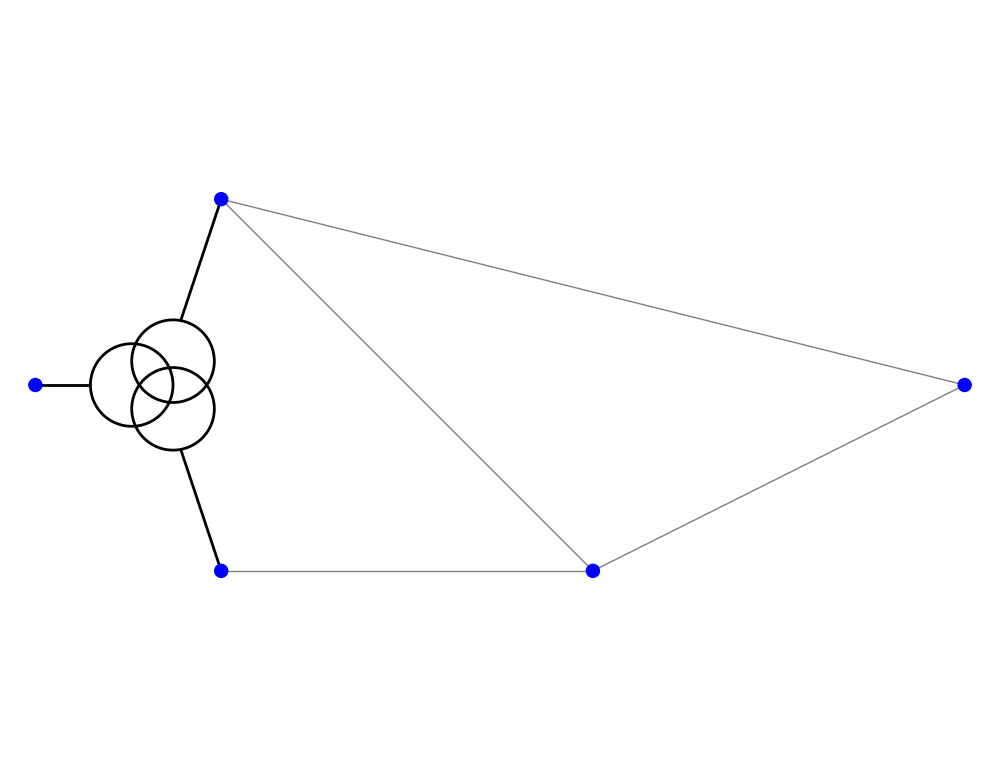

<AxesSubplot:>

In [5]:
import pandapower.plotting as plot
%matplotlib inline
plot.simple_plot(net)

Now let's run an OPF through PowerModels and look at the results (Note that the first time the runpm function is called, Julia is started in the background, which may take some time):

In [6]:
try:
    pp.runpm_ac_opf(net)
except Exception as err:
    print(err)


# or: pp.runpm(net, pm_model="ACPPowerModel")

Cannot be performed due to [WinError 3] - Can't find file python39.dll


Also, there are further parameters and options that you can add as input while calling the Optimization Problem from PandaModles:

| parameter | description | type | default |
| :--- | :--- | :---: | :--- |
| correct_pm_network_data | checks if network data is correct. If not tries to correct it | bool | True |
| silence | Suppresses information and warning messages output by PowerModels | bool | True |
| pm_model | PowerModels.jl model to use | str | "ACPPowerModel" |
| pm_solver | "main" solver| str | "ipopt" |
| pm_mip_solver | mixed integer solver| str | "cbc" |
| pm_nl_solver | nonlinear solver| str | "ipopt" |
| pm_tol | default desired convergence tolerance for solver to use | float | 1e-8 |
| pm_log_level | solver log level in power models | int | 0 |
| delete_buffer_file | If True, the .json file used by PandaModels will be deleted after optimization. | bool | True |


Since Generator 1 has the lowest cost, all required power is supplied through this generator:

In [7]:
net.res_gen

,p_mw,q_mvar,va_degree,vm_pu
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN


This however leeds to an overload in the three-winding transformer, through which g1 is connected:

In [8]:
net.res_trafo3w.loading_percent

0   NaN
Name: loading_percent, dtype: float64

Let's set some constraints for the 3W-transformer and the lines and rerun the OPF:

In [10]:
net.trafo3w["max_loading_percent"] = 50
net.line["max_loading_percent"] = 20
try:
    pp.runpm_ac_opf(net)
except:
    print("Cannot be performed due to [WinError 3] - Can't find file python39.dll")

Cannot be performed due to [WinError 3] - Can't find file python39.dll


The constraints are complied with for all lines and the 3W transformer:

In [11]:
net.res_trafo3w.loading_percent

0   NaN
Name: loading_percent, dtype: float64

In [12]:
net.res_line.loading_percent

0   NaN
1   NaN
2   NaN
3   NaN
Name: loading_percent, dtype: float64

The power is now generated by a mixture of the generators:

In [13]:
net.res_gen

,p_mw,q_mvar,va_degree,vm_pu
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN


## Accessing the full functionality of PowerModels.jl

Apart from the AC OPF used in the example above, pandapower also has an interface to run the DC OPF:

In [15]:
try:
    pp.runpm_dc_opf(net)
except:
    print("Cannot be performed due to [WinError 3] - Can't find file python39.dll")
# or: pp.runpm(net, pm_model="DCPPowerModel")
net.res_bus


Cannot be performed due to [WinError 3] - Can't find file python39.dll


,vm_pu,va_degree,p_mw,q_mvar
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


The PowerModels data structure that was passed to Julia can be accessed like this:

In [16]:
net._pm["bus"]


{'1': {'index': 1,
  'bus_i': 1,
  'zone': 1,
  'bus_type': 3,
  'vmax': 1.05,
  'vmin': 0.95,
  'va': 0.0,
  'vm': 1.01,
  'base_kv': 220.0},
 '2': {'index': 2,
  'bus_i': 2,
  'zone': 1,
  'bus_type': 1,
  'vmax': 1.05,
  'vmin': 0.95,
  'va': 0.0,
  'vm': 1.0,
  'base_kv': 110.0},
 '3': {'index': 3,
  'bus_i': 3,
  'zone': 1,
  'bus_type': 2,
  'vmax': 1.05,
  'vmin': 0.95,
  'va': 0.0,
  'vm': 1.01,
  'base_kv': 110.0},
 '4': {'index': 4,
  'bus_i': 4,
  'zone': 1,
  'bus_type': 2,
  'vmax': 1.05,
  'vmin': 0.95,
  'va': 0.0,
  'vm': 1.01,
  'base_kv': 110.0},
 '5': {'index': 5,
  'bus_i': 5,
  'zone': 1,
  'bus_type': 1,
  'vmax': 1.05,
  'vmin': 0.95,
  'va': 0.0,
  'vm': 1.0,
  'base_kv': 110.0},
 '6': {'index': 6,
  'bus_i': 6,
  'zone': 1,
  'bus_type': 1,
  'vmax': 1.05,
  'vmin': 0.95,
  'va': 0.0,
  'vm': 1.0,
  'base_kv': 220.0}}

## Timings

Comparing the runopp function (that runs an OPF through PYPOWER) and the runpm function shows that PandaModels.jl is much more performant:

In [17]:
%timeit pp.runopp(net)


hp.pandapower.run - INFO: These elements have missing power constraint values, which are considered in OPF as +- 1000 TW: ['gen']
hp.pandapower.run - INFO: These elements have missing power constraint values, which are considered in OPF as +- 1000 TW: ['gen']
hp.pandapower.run - INFO: These elements have missing power constraint values, which are considered in OPF as +- 1000 TW: ['gen']
hp.pandapower.run - INFO: These elements have missing power constraint values, which are considered in OPF as +- 1000 TW: ['gen']
hp.pandapower.run - INFO: These elements have missing power constraint values, which are considered in OPF as +- 1000 TW: ['gen']
hp.pandapower.run - INFO: These elements have missing power constraint values, which are considered in OPF as +- 1000 TW: ['gen']
hp.pandapower.run - INFO: These elements have missing power constraint values, which are considered in OPF as +- 1000 TW: ['gen']
hp.pandapower.run - INFO: These elements have missing power constraint values, which are c

1.12 s ± 89.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
try:
    %timeit pp.runpm_ac_opf(net)
except:
    print("Cannot be performed due to [WinError 3] - Can't find file python39.dll")

Cannot be performed due to [WinError 3] - Can't find file python39.dll
